In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import functools
import itertools
import pprint

import orbax.checkpoint
import numpy as np
import jax
import jax.numpy as jnp
import torch.utils.data.dataloader
import tensorflow as tf
import sqlalchemy as sa
import seaborn as sns
sns.set_theme(style='whitegrid', font_scale=1.3, palette=sns.color_palette('husl'),)
import pandas as pd
import matplotlib.pyplot as plt

from userdiffusion import samplers, unet
from userfm import cs, datasets, event_constraints, diffusion, sde_diffusion, flow_matching, utils, main as main_module, plots

2025-01-31 04:44:07.072549: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738298647.091267   20623 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738298647.096802   20623 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/root/workspace/GitHub/pmlr-v202-finzi23a/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


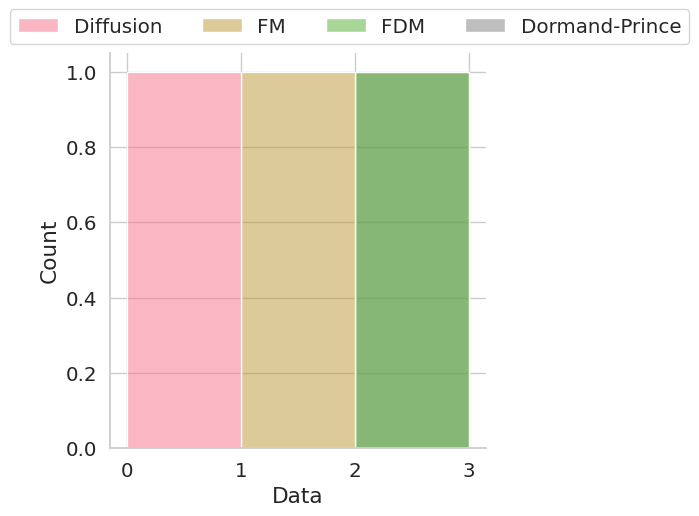

In [3]:
plot = sns.displot(
    data=pd.DataFrame(dict(Source=['Diffusion', 'FM', 'FDM', 'Dormand-Prince'], Data=range(4))),
    x='Data',
    hue='Source',
    hue_order=['Diffusion', 'FM', 'FDM', 'Dormand-Prince'],
    palette=[*sns.color_palette()[:3], 'tab:gray'],
)
sns.move_legend(
    plot,
    loc='upper center',
    ncol=3 + 1,
    title='',
    bbox_to_anchor=(.455, 1.06),
    frameon=True,
    fancybox=True,
)

In [4]:
plots.save_all_subfigures(plot, f'event_histogram.conditional')

In [5]:
# somehow, this line of code prevents a segmentation fault in nn.Dense
# when calling model.init
tf.config.experimental.set_visible_devices([], 'GPU')

In [6]:
engine = cs.get_engine()
cs.create_all(engine)
session = cs.orm.Session(engine)
session.begin()

In [7]:
config_alt_ids = {
                          # ModelTrained, Ckpt, event conditioned, dataset
    # ('18ntztqq', 'DM'): {}, # 0y35hp7d, epoch_1999, false, cs.DatasetLorenz
    # ('l5b47ntl', 'FM'): {}, # 3bjjfgwa, epoch_1999, false, cs.DatasetLorenz
    # ('7o8j9tfm', 'FM+Reg'): {}, # c0ijllm1, epoch_1999, false, cs.DatasetLorenz
    # ('gmxd1fec', 'DM'): {}, # 0y35hp7d, epoch_1999, true, cs.DatasetLorenz
    # ('8hxlur6u', 'FM'): {}, # 3bjjfgwa, epoch_1999, true, cs.DatasetLorenz
    # ('vd5kgbat', 'FM+Reg'): {}, # c0ijllm1, epoch_1999, true, cs.DatasetLorenz
    
    ('c8kjccqy', 'DM'): {}, # jzke0dh6, epoch_1999, false, cs.DatasetFitzHughNagumo
    ('mhgxsw66', 'FM'): {}, # trauw532, epoch_1999, false, cs.DatasetFitzHughNagumo
    ('jnn5czst', 'FM+Reg'): {}, # 7io88gsu, epoch_1999, false, cs.DatasetFitzHughNagumo
    ('ml7bscz4', 'DM'): {}, # jzke0dh6, epoch_1999, true, cs.DatasetFitzHughNagumo
    ('tlrj9q8k', 'FM'): {}, # trauw532, epoch_1999, true, cs.DatasetFitzHughNagumo
    ('hiyebupx', 'FM+Reg'): {}, # 7io88gsu, epoch_1999, true, cs.DatasetFitzHughNagumo
}

In [8]:
cfgs = session.execute(sa.select(cs.Config).where(cs.Config.alt_id.in_([c[0] for c in config_alt_ids])))
cfgs = {c.alt_id: c for (c,) in cfgs}
reference_cfg = cfgs[next(iter(cfgs.keys()))]
cfg_info = {}
for k in config_alt_ids:
    cfg = cfgs[k[0]]
    assert cfg.rng_seed == reference_cfg.rng_seed
    assert cfg.model.config.rng_seed == reference_cfg.model.config.rng_seed
    assert cfg.model.config.dataset == reference_cfg.model.config.dataset
    cfg_info[k] = dict(
        cfg=cfg,
    )

In [9]:
key = jax.random.key(reference_cfg.rng_seed)

In [10]:
key, key_dataset = jax.random.split(key)
reference_cfg.model.config.dataset.batch_count_test = 64
ds = datasets.get_dataset(reference_cfg.model.config.dataset, key=key_dataset)
splits = datasets.split_dataset(reference_cfg.model.config.dataset, ds)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6450/6450 [18:54<00:00,  5.68it/s]


In [11]:
constraint = event_constraints.get_event_constraint(reference_cfg.model.config.dataset)

In [12]:
df_constraint_data = pd.DataFrame({'Source': 'Data', 'Constraint Value': constraint.constraint(splits['test'])})

In [13]:
for (_, source), info in cfg_info.items():
    pred = np.load(info['cfg'].run_dir/cfg.prediction_filename)
    info['df_constraint'] = pd.DataFrame({'Source': source, 'Constraint Value': constraint.constraint(pred)})

In [14]:
NUM_BINS = 128

KL Divergence
DM
0.0260
FM
0.0280
FM+Reg
0.0280
Total Variation
DM
0.0277
FM
0.0314
FM+Reg
0.0266


/tmp/ipykernel_47029/3518656384.py:63: RuntimeWarning: divide by zero encountered in log
  kl_divergence = np.where(data_hist == 0., 0., data_hist * np.log(data_hist / (model_hist + 1e-12)))
/tmp/ipykernel_47029/3518656384.py:63: RuntimeWarning: invalid value encountered in multiply
  kl_divergence = np.where(data_hist == 0., 0., data_hist * np.log(data_hist / (model_hist + 1e-12)))


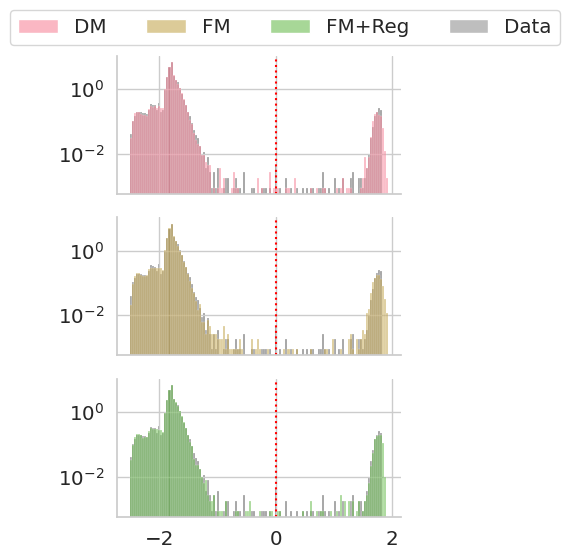

In [15]:
infos = {
    k: info for k, info in cfg_info.items()
    if not info['cfg'].model.sample_event_conditioned
}
df = pd.concat([
    info['df_constraint'] for info in infos.values()
], ignore_index=True)
bins_plot = np.histogram(np.zeros(2), bins=NUM_BINS, range=pd.concat((df, df_constraint_data))['Constraint Value'].agg(['min', 'max']))[1]
data_color = 'tab:gray'
plot = (
    sns.displot(
        data=df,
        stat='density',
        x='Constraint Value',
        row='Source',
        row_order=[c[1] for c in infos],
        hue='Source',
        hue_order=[*(c[1] for c in infos), 'Data'],
        palette=[*sns.color_palette()[:len(infos)], data_color],
        common_norm=False,
        bins=bins_plot,
        facet_kws=dict(
            # sharey=False,
        ),
        height=1.8,
        aspect=2.2,
    )
    .set(yscale='log' if isinstance(reference_cfg.model.config.dataset, cs.DatasetFitzHughNagumo) else 'linear')
    .set_titles('')
)
plot.map(
    sns.histplot,
    data=df_constraint_data,
    bins=bins_plot,
    stat='density',
    color=data_color,
    x='Constraint Value',
    zorder=-1,
).set_xlabels('').set_ylabels('')
for (row, col, hue), data in plot.facet_data():
    ax = plot.axes[row][col]
    ax.axvline(x=0, c='r', ls=':')
    ax.xaxis.set_tick_params(labelbottom=True)
    ax.yaxis.set_tick_params(labelleft=True)
    if row != len(plot.row_names) - 1:
        ax.xaxis.set_tick_params(labelbottom=False)
plot.tight_layout()
sns.move_legend(
    plot,
    loc='upper center',
    ncol=len(cfg_info) + 1,
    title='',
    bbox_to_anchor=(.455, 1.06),
    frameon=True,
    fancybox=True,
)
data_hist, bins_kl = np.histogram(df_constraint_data['Constraint Value'], bins=NUM_BINS, range=df_constraint_data['Constraint Value'].agg(['min', 'max']))
data_hist = data_hist / len(df_constraint_data)
print('KL Divergence')
for (row, col, hue), data in plot.facet_data():
    print(plot.row_names[row])
    model_hist = np.histogram(data['Constraint Value'], bins=bins_kl)[0] / len(data)
    kl_divergence = np.where(data_hist == 0., 0., data_hist * np.log(data_hist / (model_hist + 1e-12)))
    print(f'{kl_divergence.sum():.4f}')
    
print('Total Variation')
data_hist, bins_tv = np.histogram(df_constraint_data['Constraint Value'], bins=NUM_BINS, range=df_constraint_data['Constraint Value'].agg(['min', 'max']), density=True)
for (row, col, hue), data in plot.facet_data():
    print(plot.row_names[row])
    model_hist = np.histogram(data['Constraint Value'], bins=bins_tv, density=True)[0]
    total_variation = 0.5 * np.abs(model_hist - data_hist) * np.diff(bins_tv)
    print(f'{total_variation.sum():.4f}')

In [16]:
plots.save_all_subfigures(plot, f'event_histogram.unconditional.{reference_cfg.model.config.dataset.__class__.__name__}')

/tmp/ipykernel_47029/2440675782.py:6: RuntimeWarning: divide by zero encountered in log
  kl_divergence = np.where(data_hist == 0., 0., data_hist * np.log(data_hist / (model_hist + 1e-12)))
/tmp/ipykernel_47029/2440675782.py:6: RuntimeWarning: invalid value encountered in multiply
  kl_divergence = np.where(data_hist == 0., 0., data_hist * np.log(data_hist / (model_hist + 1e-12)))


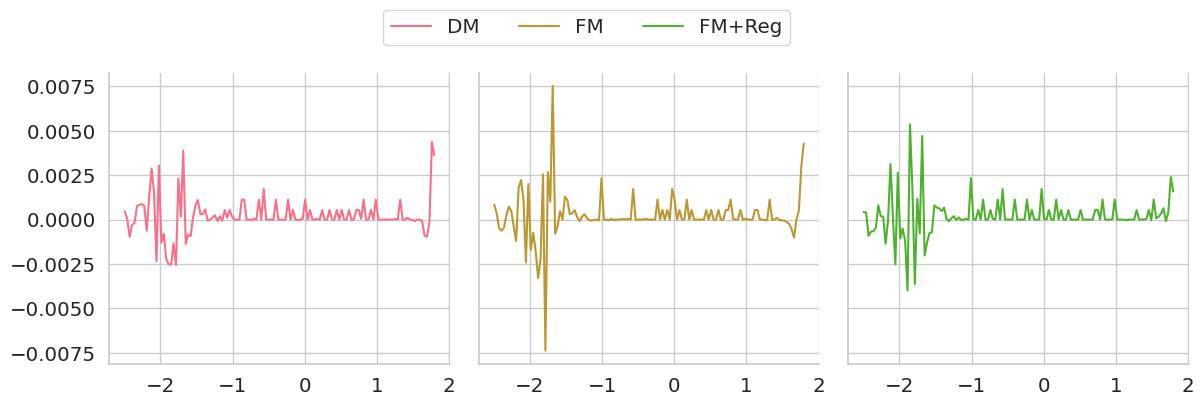

In [17]:
bins_kl = np.histogram(np.zeros(2), bins=NUM_BINS, range=df_constraint_data['Constraint Value'].agg(['min', 'max']))[1]
data_hist = np.histogram(df_constraint_data['Constraint Value'], bins=bins_kl)[0] / len(df_constraint_data)
df_kls = []
for (row, col, hue), data in plot.facet_data():
    model_hist = np.histogram(data['Constraint Value'], bins=bins_kl)[0] / len(data)
    kl_divergence = np.where(data_hist == 0., 0., data_hist * np.log(data_hist / (model_hist + 1e-12)))
    df_kl = pd.DataFrame({'Source': plot.row_names[row], 'Bins': bins_kl[:-1], 'KL Divergence': kl_divergence})
    df_kls.append(df_kl)
df_kl = pd.concat(df_kls, ignore_index=True)
plot_kl = (
    sns.relplot(
        kind='line',
        data=df_kl,
        x='Bins',
        y='KL Divergence',
        col='Source',
        col_order=[c[1] for c in infos],
        hue='Source',
        hue_order=[*(c[1] for c in infos)],
        palette=[*sns.color_palette()[:len(infos)]],
        facet_kws=dict(
            # sharex=False,
        ),
        height=4.2,
        aspect=1,
    )
    # .set(yscale='log' if isinstance(reference_cfg.model.config.dataset, cs.DatasetFitzHughNagumo) else 'linear')
    .set_titles('')
    .set_xlabels('')
    .set_ylabels('')
)
sns.move_legend(
    plot_kl,
    loc='upper center',
    ncol=len(cfg_info),
    title='',
    bbox_to_anchor=(.455, 1.06),
    frameon=True,
    fancybox=True,
)

KL Divergence
DM
0.3011
FM
0.3468
FM+Reg
0.2084
Total Variation
DM
0.1192
FM
0.2164
FM+Reg
0.1168


/tmp/ipykernel_47029/14887829.py:64: RuntimeWarning: divide by zero encountered in log
  kl_divergence = np.where(data_hist == 0., 0., data_hist * np.log(data_hist / (model_hist + 1e-12)))
/tmp/ipykernel_47029/14887829.py:64: RuntimeWarning: invalid value encountered in multiply
  kl_divergence = np.where(data_hist == 0., 0., data_hist * np.log(data_hist / (model_hist + 1e-12)))


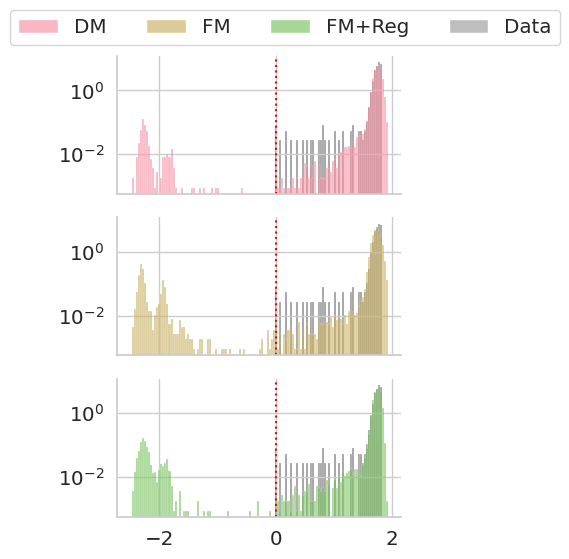

In [18]:
infos = {
    k: info for k, info in cfg_info.items()
    if info['cfg'].model.sample_event_conditioned
}
df = pd.concat([
    info['df_constraint'] for info in infos.values()
], ignore_index=True)
df_constraint_event_data = df_constraint_data.loc[df_constraint_data['Constraint Value'] > 0]
data_color = 'tab:gray'
plot = (
    sns.displot(
        data=df,
        stat='density',
        x='Constraint Value',
        row='Source',
        row_order=[c[1] for c in infos],
        hue='Source',
        hue_order=[*(c[1] for c in infos), 'Data'],
        palette=[*sns.color_palette()[:len(infos)], data_color],
        common_norm=False,
        bins=bins_plot,
        facet_kws=dict(
            # sharex=False,
        ),
        height=1.8,
        aspect=2.2,
    )
    .set(yscale='log' if isinstance(reference_cfg.model.config.dataset, cs.DatasetFitzHughNagumo) else 'linear')
    .set_titles('')
)
plot.map(
    sns.histplot,
    data=df_constraint_event_data,
    bins=bins_plot,
    stat='density',
    color=data_color,
    x='Constraint Value',
    zorder=-1,
).set_xlabels('').set_ylabels('')
for (row, col, hue), data in plot.facet_data():
    ax = plot.axes[row][col]
    ax.axvline(x=0, c='r', ls=':')
    ax.xaxis.set_tick_params(labelbottom=True)
    ax.yaxis.set_tick_params(labelleft=True)
    if row != len(plot.row_names) - 1:
        ax.xaxis.set_tick_params(labelbottom=False)
plot.tight_layout()
sns.move_legend(
    plot,
    loc='upper center',
    ncol=len(cfg_info) + 1,
    title='',
    bbox_to_anchor=(.455, 1.06),
    frameon=True,
    fancybox=True,
)

print('KL Divergence')
data_hist, bins_kl = np.histogram(df_constraint_event_data['Constraint Value'], bins=NUM_BINS, range=df_constraint_event_data['Constraint Value'].agg(['min', 'max']))
data_hist = data_hist / len(df_constraint_event_data)
for (row, col, hue), data in plot.facet_data():
    print(plot.row_names[row])
    model_hist = np.histogram(data['Constraint Value'], bins=bins_kl)[0] / len(data)
    kl_divergence = np.where(data_hist == 0., 0., data_hist * np.log(data_hist / (model_hist + 1e-12)))
    print(f'{kl_divergence.sum():.4f}')
    
print('Total Variation')
data_hist, bins_tv = np.histogram(df_constraint_event_data['Constraint Value'], bins=NUM_BINS, range=df_constraint_event_data['Constraint Value'].agg(['min', 'max']), density=True)
for (row, col, hue), data in plot.facet_data():
    print(plot.row_names[row])
    model_hist = np.histogram(data['Constraint Value'], bins=bins_tv, density=True)[0]
    total_variation = 0.5 * np.abs(model_hist - data_hist) * np.diff(bins_tv)
    print(f'{total_variation.sum():.4f}')

In [19]:
plots.save_all_subfigures(plot, f'event_histogram.conditional.{reference_cfg.model.config.dataset.__class__.__name__}')

/tmp/ipykernel_47029/1416192705.py:6: RuntimeWarning: divide by zero encountered in log
  kl_divergence = np.where(data_hist == 0., 0., data_hist * np.log(data_hist / (model_hist + 1e-12)))
/tmp/ipykernel_47029/1416192705.py:6: RuntimeWarning: invalid value encountered in multiply
  kl_divergence = np.where(data_hist == 0., 0., data_hist * np.log(data_hist / (model_hist + 1e-12)))


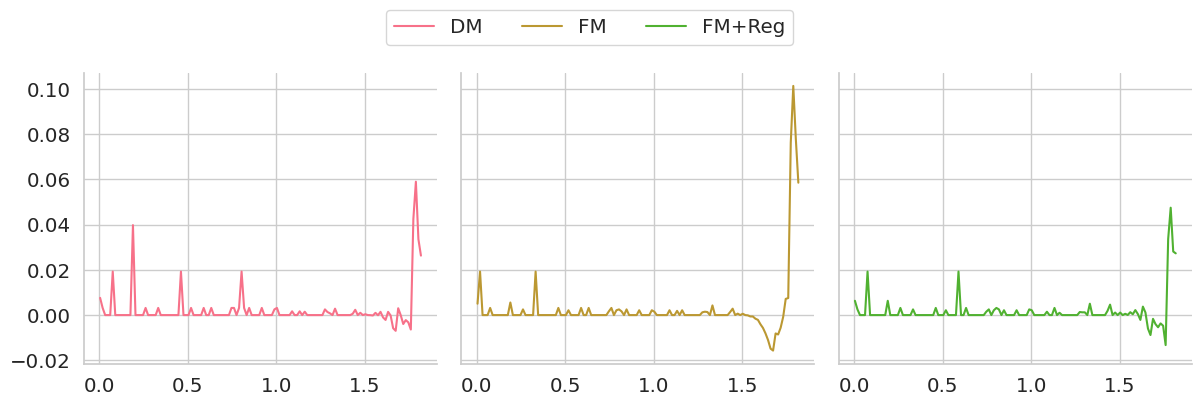

In [20]:
bins_kl = np.histogram(np.zeros(2), bins=128, range=df_constraint_event_data['Constraint Value'].agg(['min', 'max']))[1]
data_hist = np.histogram(df_constraint_event_data['Constraint Value'], bins=bins_kl)[0] / len(df_constraint_event_data)
df_kls = []
for (row, col, hue), data in plot.facet_data():
    model_hist = np.histogram(data['Constraint Value'], bins=bins_kl)[0] / len(data)
    kl_divergence = np.where(data_hist == 0., 0., data_hist * np.log(data_hist / (model_hist + 1e-12)))
    df_kl = pd.DataFrame({'Source': plot.row_names[row], 'Bins': bins_kl[:-1], 'KL Divergence': kl_divergence})
    df_kls.append(df_kl)
df_kl = pd.concat(df_kls)
plot_kl = (
    sns.relplot(
        kind='line',
        data=df_kl,
        x='Bins',
        y='KL Divergence',
        col='Source',
        col_order=[c[1] for c in infos],
        hue='Source',
        hue_order=[*(c[1] for c in infos)],
        palette=[*sns.color_palette()[:len(infos)]],
        facet_kws=dict(
            # sharex=False,
        ),
        height=4.2,
        aspect=1,
    )
    # .set(yscale='log' if isinstance(reference_cfg.model.config.dataset, cs.DatasetFitzHughNagumo) else 'linear')
    .set_titles('')
    .set_xlabels('')
    .set_ylabels('')
)
sns.move_legend(
    plot_kl,
    loc='upper center',
    ncol=len(cfg_info),
    title='',
    bbox_to_anchor=(.455, 1.06),
    frameon=True,
    fancybox=True,
)

In [21]:
infos = {
    k: info for k, info in cfg_info.items()
    if not info['cfg'].model.sample_event_conditioned
}
print('Event Likelihood: Direct Monte-Carlo')
for (_, source), info in ((('', 'Data'), {'df_constraint': df_constraint_data}), *infos.items()):
    is_event = info['df_constraint']['Constraint Value'] > 0
    print(f'{source}: P(E) = {is_event.mean():.3f}+-{is_event.std()/jnp.sqrt(len(is_event)):.3f}')

Event Likelihood: Direct Monte-Carlo
Data: P(E) = 0.034+-0.001
DM: P(E) = 0.032+-0.001
FM: P(E) = 0.034+-0.001
FM+Reg: P(E) = 0.033+-0.001
